# User Guide
## Examples on how to store and retrieve data using StorageGroup 

In [1]:
from datetime import datetime
import os
import numpy as np
import pandas as pd
import xarray as xr
from tonik import StorageGroup 

The hierarchy of a storage group is sites, sensors, and channels. Data can be stored under each of them. We will start by generating fake spectrogram data and then store that under a channel.

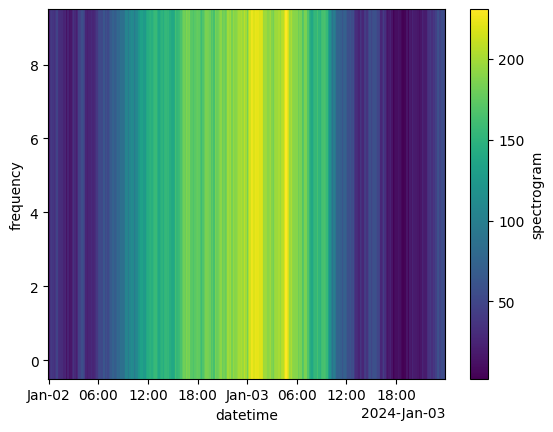

In [2]:
dates = pd.date_range("2024-01-02", freq='10min', periods=288)
data = np.abs(np.cumsum(np.random.normal(0, 8., len(dates))))
data = np.tile(data, (10, 1))
freqs = np.arange(10)
xrd = xr.Dataset({'spectrogram': xr.DataArray(data, coords=[freqs, dates],
                                              dims=['frequency', 'datetime'])})
fig = xrd['spectrogram'].plot()

Now we will store the data under two different sites of the same experiment using the same sensor and channel names for both.

In [7]:
g = StorageGroup('test_experiment', rootdir='/tmp')
st1 = g.get_store(site='MDR1', sensor='00', channel='HHZ')
st2 = g.get_store(site='MDR2', sensor='00', channel='HHZ')
st1.save(xrd)
st2.save(xrd)
g

Group: test_experiment
|__ MDR1
|  |__ 00
|     |__ HHZ
|__ MDR2
   |__ 00
      |__ HHZ

Next we want to retrieve the data we just saved. Before retrieving data we have to set the timespan over which we want to retrieve data.

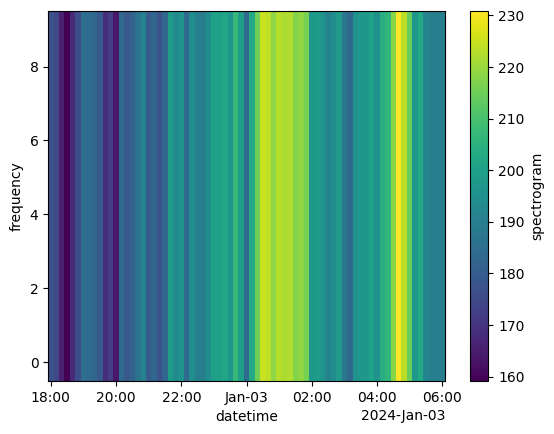

In [4]:
g.starttime = datetime(2024, 1, 2, 18, 0, 0)
g.endtime = datetime(2024, 1, 3, 6, 0, 0)
st = g.get_store('MDR2', '00', 'HHZ')
st('spectrogram').plot()

In [5]:
# Now start the API server by running the following command in a terminal
# tonik_api --rootdir examples

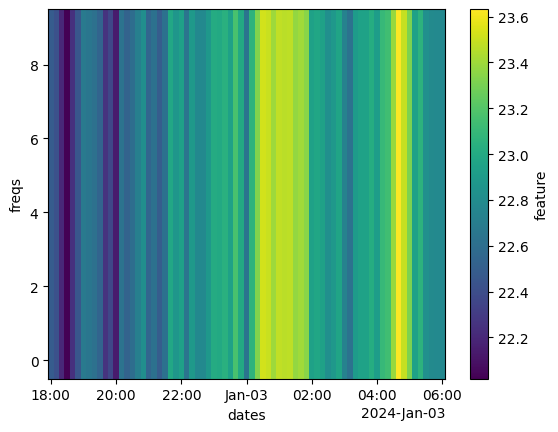

In [6]:
url = "http://localhost:8003/feature?"
url += f"group={g.name}&site=MDR2&sensor=00&channel=HHZ&name=spectrogram"
url += f"&starttime={g.starttime.isoformat()}&endtime={g.endtime.isoformat()}" 
spec = pd.read_csv(url, parse_dates=True, index_col=[0, 1], date_format='ISO8601').to_xarray()
spec.transpose('freqs', 'dates')['feature'].plot()